In [1]:
import group_data as gd

In [2]:
def parse_GMR_genotype(genotype):
    """get the GMR and UAS keys in a given genotype"""
    print genotype
    gcamp_idx =  genotype.find('GCaMP6f')
    GFP_idx = genotype.find('GFP')
    gmr_idx = genotype.find('GMR')
    gmr_str = genotype[gmr_idx+3:gmr_idx+8]
    if gcamp_idx > 0:
        return {'uas':'GCaMP6f','gal4':gmr_str}
    elif GFP_idx > 0:
        return {'uas':'eGFP','gal4':gmr_str}

In [3]:
def get_line_database():
    #print line_name
    import cPickle
    f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database()
    muscle_names = list()
    for key in line_database[line_name].keys():
        if line_database[line_name][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

In [4]:
def get_update_list(file_name ='nnls_fits_no_bk_dF_F.cpkl', 
                     swarms = gd.swarms,
                     replace = False):
    """ if replace is False this will scan the database to 
    create a 'pathlist' containing just flies that don't have 
    a file with file_name, otherwise all the flies in swarms will be used"""
    import os
    update_flylist = list()
    for swarm_name,swarm in swarms.items():
        print swarm_name
        for fly in swarm.flies:
            try:
                if not(replace):
                    if os.path.exists(fly.fly_path + 'nnls_fits_no_bk_dF_F.cpkl'):
                        pass
                        #print str(fly.fly_num) + ' exists'
                    else:
                        update_flylist.append((fly.fly_path,'GMR22H05'))
                else:
                    update_flylist.append(fly)
            except Exception as er:
                print er
    return update_flylist

In [6]:
#flylist = gd.GMR22H05_pr_swarm.flies + gd.GMR22H05_prc_swarm.flies + gd.GMR22H05_swarm.flies
#flylist = gd.get_update_list(file_name = 'nnls_fits_bk_sub_F.cpkl',swarms = gd.swarms)
#fly_paths.append((fly.fly_path,key.split('_')[0]))
import flylib
reload(gd)
flylist = gd.swarms['GMR40D04_yr'].flies #reload
#flylist = flylib.NetSquadron(flylist).flies

In [8]:
#fit to each fly in serial (block) but break up the data to run in parallel within a fly.
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1]


In [9]:
def fit_to_model(imchunk,model, mode = 'pinv',fit_pix_mask = None,baseline = None):
    import numpy as np
    #im_array = (imchunk-baseline)#/baseline
    im_array = imchunk-baseline#/baseline
    imshape = np.shape(im_array[0])
    im_array = im_array.reshape((-1,imshape[0]*imshape[1]))
    if mode == 'nnls':
        fits = np.empty((np.shape(model)[0],np.shape(im_array)[0]))
        for i,im2 in enumerate(im_array):
            im = im2.copy()
            im[~np.isfinite(im)] = 0
            from scipy.optimize import nnls
            if not(fit_pix_mask is None):
                fits[:,i] = nnls(model[:,fit_pix_mask].T,im[fit_pix_mask])[0]
            else:
                fits[:,i] = nnls(model.T,im)[0]
    else:
        im = im_array
        print np.shape(im_array)
        from numpy.linalg import pinv
        if not(fit_pix_mask is None):
            fits = np.dot(pinv(model[:,fit_pix_mask]).T,im[:,fit_pix_mask].T)
        else:
            fits = np.dot(pinv(model).T,im)
    return fits

#extract the data give the fly_path and 'line_name'
def extract_signals(fly):
    import muscle_model as mm
    import numpy as np
    import h5py
    import cv2
    model_type = 'volumetric'
    #model_type = 'masks'
    #load the reference frame of the cofocal data and that of the imaged fly
    confocal_model = mm.GeometricModel(filepath = gd.muscle_anatomy_dir + 'confocal_outline_model.cpkl')
    confocal_view = mm.ModelViewMPL(confocal_model)
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    #get the transformation matrix A and compose with a scaling using a scaling of s
    #to construct a transformation for homogenious vectors
    s = 1 #scale
    A = fly_frame.get_transform(confocal_model.frame)
    Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    #parse the GMR genotype to get the line name
    line_name = parse_GMR_genotype(fly.get_genotype())['gal4']
    #get the list of muscles for a given line
    muscles = get_muscle_list(line_name)
    muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    #get a reference to the image data
    fly_record = h5py.File(fly.fly_path + 'fly_record.hdf5','r')
    exp_record = fly_record['experiments'].values()[0]
    imgs = exp_record['tiff_data']['images']
    #the output shape of the warped model
    output_shape = np.shape(imgs[0])
    if model_type == 'masks':
        #get the mask of all the muscles for fit
        masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
        #create the model using only the muscles that express in a given line
        model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])
        #construct a mask do reduce the projection to just the data within the model
        fit_pix_mask = np.sum(model,axis=0) > 0
    if model_type == 'volumetric':
        model_data = h5py.File(gd.muscle_anatomy_dir + 'flatened_model.hdf5','r')
        model_muscles = [np.array(model_data[muscle]) for muscle in muscles]
        output_shapes = [output_shape for muscle in muscles]
        transforms = [Ap[:-1,:] for muscle in muscles]
        model = v.map(cv2.warpAffine,model_muscles,transforms,output_shapes)
        model = np.vstack([muscle.T.ravel() for muscle in model])
        #model = np.vstack([cv2.warpAffine(np.array(model_data[muscle]), \
        #                               Ap[:-1,:],output_shape).T.ravel() \
        #                for muscle in muscles])
        fit_pix_mask = np.ones_like(model[0]) > 0

    f = open(fly.fly_path + 'epoch_data.cpkl')
    import cPickle
    baseline_range = cPickle.load(f)['baseline_F']
    f.close()
    baseln = np.mean(imgs[baseline_range],axis = 0)
    
    chnk_sz = 2000
    num_samps = np.shape(imgs)[0]
    chunks = [slice(x,x+chnk_sz if x+chnk_sz < num_samps else num_samps) for x in range(0,num_samps,chnk_sz)]
    
    img_chunks = [np.array(imgs[chunk]) for chunk in chunks]
    models = [model for chunk in chunks]
    modes = ['nnls' for chunk in chunks]
    fit_pix_masks = [fit_pix_mask for chunk in chunks]
    baselines = [baseln for chunk in chunks]
    
    fits = v.map(fit_to_model,img_chunks,models,modes,fit_pix_masks,baselines)
    #fit = fit_to_model(imchunk,model,mode = 'nnls',fit_pix_mask = fit_pix_mask)
    return np.hstack(fits),muscles

In [10]:
[fly.fly_num for fly in flylist]

[638, 639, 640]

In [14]:
import numpy as np
fly_fails = list()
for fly in flylist[:1]:
    print fly.fly_path
    try:
        fits,muscles = extract_signals(fly)
        f = open(fly.fly_path + 'nnls_fits_bk_sub_F.cpkl','wb')
        import cPickle as cpkl
        cpkl.dump({'fits':fits,'muscles':muscles},f)
        f.close()
    except IOError as err:
        fly_fails.append((fly.fly_num,err))
        print err 

/media/FlyDataC/FlyDB/Fly0638/
+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR40D04-GAL4}attP2/+


In [9]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [19]:
pkldata = flylist[0].get_pkl_data('nnls_fits_bk_sub_F.cpkl')

hg4


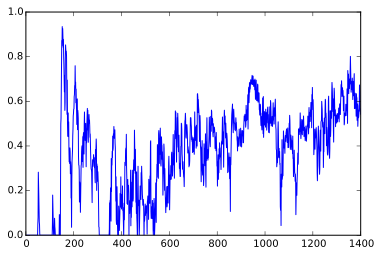

In [20]:
plot(pkldata['fits'][1][:7000:5])
print(pkldata['muscles'][1])

In [13]:
from IPython.display import display, Math, Latex 

In [97]:
%%latex
\begin{align}
\mathbf{X} \boldsymbol{\beta} = {\mathbf{{Y}}}\\
\mathbf{X} \mathbf{B} = {\mathbf{\hat{Y}} + \mathbf{E}}\\
\mathbf{X} = \begin{bmatrix} 
             \mathbf{m_{1}} \ldots \mathbf{m_{n}}
             \end{bmatrix}\\
\end{align}

<IPython.core.display.Latex object>

In [84]:
%%latex
\begin{align}
\mathbf{X} \mathbf{B} = {\mathbf{{Y}}}\\
\end{align}

<IPython.core.display.Latex object>

In [86]:
%%latex
\begin{align}
\mathbf{X} \mathbf{B} = {\mathbf{\hat{Y}} + \mathbf{E}}\\
\end{align}

<IPython.core.display.Latex object>

In [125]:
%%latex
\begin{align}
\mathbf{X} = \begin{bmatrix} 
             \mathbf{m_{1}} \ldots \mathbf{m_{j}}
             \end{bmatrix}\\
\end{align}

<IPython.core.display.Latex object>

In [124]:
%%latex
\begin{align}
&\mathbf{G}^*(i,z) =  \mathbf{C}(z)* \mathbf{S_{i,z}}\\
&\mathbf{x_{i}} = vec(\sum_{z=1}^{230}{{\mathbf{G}^*(i,z) \frac{\sum\mathbf{G}^*(z,i)}{\sum\mathbf{C}(z)}}} )\\
\end{align}

<IPython.core.display.Latex object>

In [102]:
%%latex
\begin{align}
d(z)= 2 \cdot f \cdot NA \frac{\mid{p_{z}(z_{i} - l_{o})}\mid}{p_{z}z_{i}} + w\\
\end{align}

<IPython.core.display.Latex object>

In [ ]:
obj_mag = 10.0 #10x objective
tube_fl = 200.0 #mm tube lens focal length
obj_fl = tube_fl/obj_mag #mm objective focal length
obj_NA = 0.45 #objective NA
obj_entrance_pupil = 2*obj_fl*obj_NA
voxel_ptch = (0.76/1000.0,0.76/1000.0,2.98/1000.0) #mm
fslice = 25 #focal slice - the slice in the confocal stack that is at the center of focus point in the reconstructed model 
working_distance = 4.0 #mm, not used in the calculation
wavelength = 530.0/(1000*1000) #mm
#airy_disk = 2*(0.61*wavelength)/obj_NA
airy_disk = wavelength/(2*obj_NA) #diffraction limit
#The airy disk should be around the confocal-image voxel pitch 
#depending on the NA of the objectve used to collect the confocal stack 
airy_disk = airy_disk*10 #the model seems to do much better fort the actual
#focal slice than what we collect - possibly due to motion
slice_delta = (slice_idx-fslice+0.5)*voxel_ptch[2]

In [129]:
%%latex
solid angle of objective
\begin{align}
2\pi(1-cos\theta)
\end{align}

<IPython.core.display.Latex object>

In [138]:
import numpy as np
sr = 2*np.pi*(1-np.cos(np.deg2rad(61.0)))
print sr
print sr/(2*np.pi)

3.23703662447
0.515190379754
